# How to Easily Perform Outlier Detection In Python For Machine Learning, #2
## Earth is an outlier - the code, part 2
![](images/pixabay.jpg)
<figcaption style="text-align: center;">
    Image by <a href="https://pixabay.com/users/alexas_fotos-686414/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=1744091">Alexa</a> from <a href="https://pixabay.com//?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=1744091">Pixabay</a>
</figcaption>

### Introduction

The first question to ask before starting outlier detection is "Does my dataset even have outliers?". While the usual answer is "Yes", it is always recommended to sniff the hint of outlier presence in the air before making big efforts (like using machine learning models) to isolate them.

So, we will start off this second part of our outlier detection tutorial series by looking at general methods of detecting the presence of outliers like data visualization. Then, we will continue the post by talking about methods to detect both univariate and multivaraite outliers.
 
Let's get started!

### The dataset to be used

We'll be using the Diamonds dataset throughout the tutorial. It is large enough for it to not be a toy dataset and it has got a nice combination of numeric and categorical features. 

In [2]:
import seaborn as sns

diamonds = sns.load_dataset("diamonds")
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Our eventual task after outlier detection is predicting the carat of diamonds given its physical characteristics and price:

In [3]:
diamonds.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

Before we get to that part, we want to detect and isolate the outliers to make our dataset as clean as possible (it is relatively clean now).

So, let's extract the feature and target arrays and encode the categorical columns using OrdinalEncoder class from Sklearn:

In [5]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

# Extract feature and target arrays
X, y = diamonds.drop("carat", axis=1), diamonds["carat"]
# Select categorical column names
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Encode categoricals
X.loc[:, cats] = OrdinalEncoder().fit_transform(X[cats])

Now, we are ready...

### Do outliers even exist?

...to answer the question "Do outliers even exist"? The first step is to look at the summary statistics of the target variable - carat. We are looking if there are suspicious enough gaps between the minimum, mean and maximum of the target.

In [6]:
y.describe()

count    53940.000000
mean         0.797940
std          0.474011
min          0.200000
25%          0.400000
50%          0.700000
75%          1.040000
max          5.010000
Name: carat, dtype: float64

The values are 0.2, 0.8 and 5.01 for minimum, mean and maximum respectively. The large gaps between the minimum and maximum and between mean and the maximum already suggest there might be outliers (remember, outliers are often the extreme datapoints in distributions).

Let's confirm this suspicion by plotting the histogram of the target:

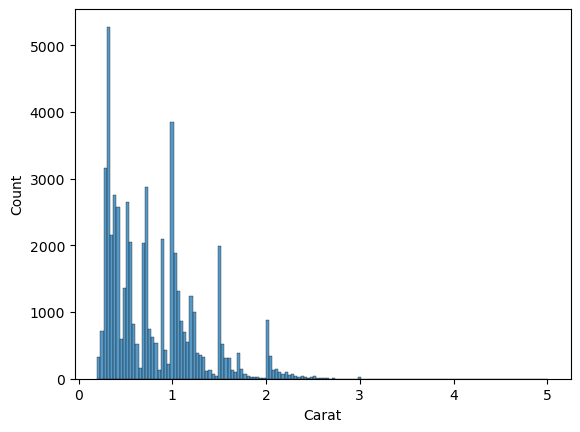

In [8]:
import matplotlib.pyplot as plt
sns.histplot(y)

plt.xlabel("Carat");

As we can see, the bulk of the histogram is between 0.2 and 3 carats. But the right tail of histogram goes up to 5, but we can't see any bins there. If you see a histogram with long left or right tail but no bins in the tails, this means there is a small quantity of extreme values (outliers) in the distribution.

Now, let's look at the features array:

In [9]:
X.drop(cats, axis=1).describe()

,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


After excluding the categorical features, we can probably guess that price is the most important feature. And like carat, we can see big differences between the mean price and the cheapest and most expensive diamonds. Let's plot a histogram again:

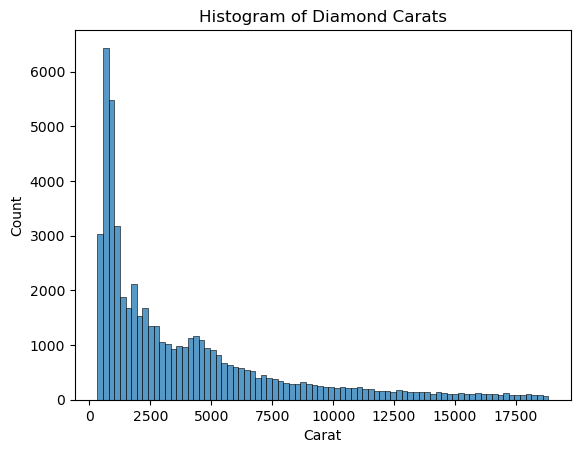

In [10]:
sns.histplot(X["price"])

plt.title("Histogram of Diamond Carats")
plt.xlabel("Carat");

We can see that the majority of datapoints lie below 5000$; the rest of the bins have very low height. This is getting tricky - do we consider all the points above 5000 as outliers, now? That would be a large proportion of the dataset. 

Let's look more closely by plotting a boxplot of diamond cut quality versus price. The cut quality is given in descending order from left to right. 

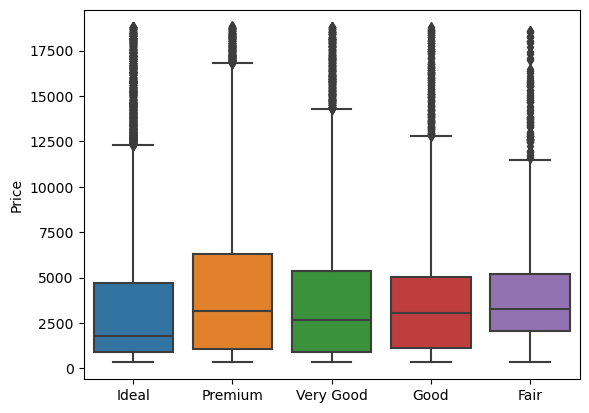

In [11]:
sns.boxplot(x="cut", y="price", data=diamonds, whis=2)

plt.xlabel("")
plt.ylabel("Price");

Even though we see many outliers in the plot marked with circles above the whiskers of the boxes, we can't safely conclude they are outliers.

If you pay attention, the highest quality, ideal diamonds have prices around 2000\$ (look at the median) and yet, the lowest quality, fair diamonds cost much more, around 3000\\$ . This suggests that there exists some hidden multivariate relationships between the features of the dataset, and that we can't draw conclusions from just single and two-variable plots.

Actually, this is the case for almost all datasets. Plain descriptive statistics and simple plots can only hint the presence of outliers. And since we can't really see the big picture relationships among all features using these methods, we have to turn to more sophisticated techniques.

### Univariate outlier detection

First, let's look at techniques that allow us to detect outliers in single distributions, like our target array of diamond carats.

One of the most popular methods to perform outlier detection on such univariate datasets is using plain-old z-scores. Recall that a z-score of a datapoint tells us how many standard deviations it is away from the mean. 

For example, if distribution A have a mean of 5 and standard deviation of 3.2, the sample 17.2 would have a z-score of (17.2 - 5) / 3.2 = 3.8125.

We can calculate the z-score of all elements in an array using the `zscore` function from `scipy`:

In [13]:
from scipy.stats import zscore

zscore(y).abs()[:5]

0    1.198168
1    1.240361
2    1.198168
3    1.071587
4    1.029394
Name: carat, dtype: float64

In statistics, a z-score of 3 is commonly used as a threshold between inliers and outliers. So, using array filtering we can mark any samples as outliers if the absolute value of their z-score is higher than 3:

In [14]:
from scipy.stats import zscore

is_outlier = zscore(y).abs() > 3
outliers_y = y[is_outlier]

num_outliers = len(outliers_y)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(y):.3f}")

The number of outliers: 439
Percentage of outliers: 0.008


The method marks 0.8% of samples as outliers and that's not a coincidence. The idea of using a z-score of three as a threshold for outliers comes from the Empirical Rule.

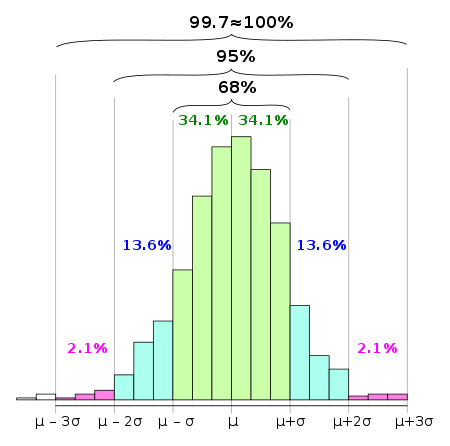

CC BY-SA

The [Empirical Rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) states that data within one, two, three standard deviations or z-scores roughly represent 68%, 95% and 99.7% of the  distribution, respectively.

So, if a sample have a z-score higher than 3, we can safely conclude that is an extreme value since it doesn't belong to roughly 99.7% of the dataset.

We found 439 outliers using the z-scores method but can we really trust this output? Actually, we can't. 

The Empirical Rule, and in turn, z-scores are only appropriate to normally distributed data. And from the histogram of diamond carats we saw earlier, we know for a fact that our target, y, is not normally distributed:

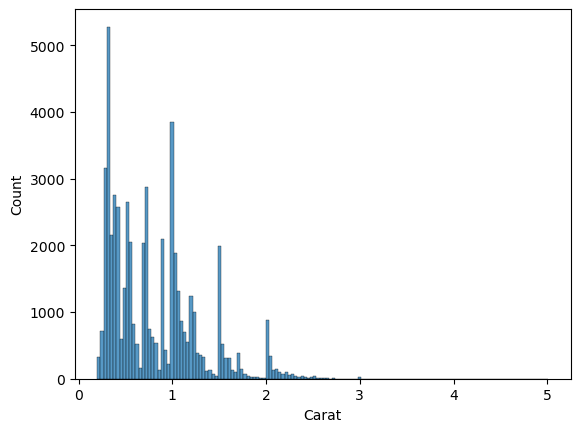

So, we must take another approach now.

### Modified z-scores

It is the standard deviation but with the median at the core.

In [85]:
from scipy.stats import median_abs_deviation

median_abs_deviation(y)

0.32000000000000006

Now, if we use the MAD score in z-scores formula, it becomes modified z-scores:

In [206]:
from pyod.models.mad import MAD

mad = MAD().fit(y.values.reshape(-1, 1))

labels = pd.Series(mad.labels_)
labels.sample(5)

40985    0
32491    0
51989    0
49503    0
6988     0
dtype: int64

In [209]:
outliers_y_mad = y[labels == 1]

num_outliers = len(outliers_y_mad)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(y):.3f}")

The number of outliers: 222
Percentage of outliers: 0.004


### Multivariate outlier detection with PyOD

In [211]:
from pyod.models.lof import LOF

lof = LOF(n_neighbors=30).fit(X)

labels = pd.Series(lof.labels_)
outliers_X_lof = X[labels == 1]

num_outliers = len(outliers_X_lof)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.3f}")

The number of outliers: 5394
Percentage of outliers: 0.100


In [214]:
from pyod.models.iforest import IForest

iforest = IForest(n_estimators=500).fit(X)

labels = pd.Series(iforest.labels_)
outliers_X_iforest = X[labels == 1]

num_outliers = len(outliers_X_iforest)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.3f}")

The number of outliers: 5394
Percentage of outliers: 0.100


### Contamination

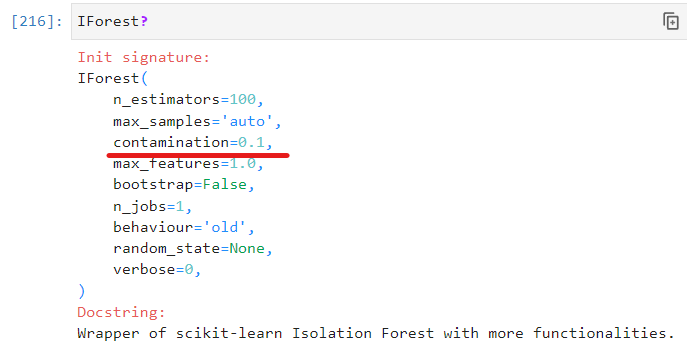

In [217]:
iforest = IForest().fit(X)

iforest.decision_scores_[:10]

array([-0.01789882,  0.03646687,  0.09759012, -0.06977119, -0.02610138,
        0.01991868,  0.00180873, -0.00440727,  0.08668909,  0.04439745])

In [218]:
from pyod.models.knn import KNN

knn = KNN().fit(X)

knn.decision_scores_[:10]

array([11.56034602, 12.46189392, 13.42818305,  6.09343909,  5.39804594,
        5.90354978,  5.12414871,  5.41214375,  8.1313775 ,  6.87590721])

### Probability scores

In [227]:
from pyod.models.iforest import IForest

iforest = IForest(n_estimators=1000).fit(X)

probs = iforest.predict_proba(X)
probs[:10]

array([[0.6595839 , 0.3404161 ],
       [0.49970223, 0.50029777],
       [0.30612256, 0.69387744],
       [0.73151238, 0.26848762],
       [0.58695384, 0.41304616],
       [0.42048955, 0.57951045],
       [0.53045075, 0.46954925],
       [0.6171362 , 0.3828638 ],
       [0.33290998, 0.66709002],
       [0.46752207, 0.53247793]])

In [230]:
threshold = 0.9

is_outlier = probs[:, 1] > threshold
outliers_X_probs = X[is_outlier]

num_outliers = len(outliers_X_probs)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.4f}")

The number of outliers: 10
Percentage of outliers: 0.0002


### Conclusion